In [ ]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time

In [ ]:
def tensor_to_Image(tensor):
  tensor=tensor*255
  tensor=np.array(tensor,dtype=np.uint8)
  if(tensor.ndim>3):
    tensor=tensor[0]
  return Image.fromarray(tensor)

In [ ]:
def load_img(image_path):
  max_dim=512
  img=tf.io.read_file(image_path)
  img=tf.io.decode_image(img,channels=3)
  img=tf.image.convert_image_dtype(img,tf.float32)
  shape=tf.cast(tf.shape(img)[:-1],tf.float32)
  long_dim=max(shape)
  scale=max_dim/long_dim
  new_shape=tf.cast(shape*scale,tf.int32)
  img=tf.image.resize(img,new_shape)
  img=img[tf.newaxis,:]
  return img

In [ ]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
content_img=load_img(content_path)
style_img = load_img('/content/5.jpg')

(-0.5, 511.5, 404.5, -0.5)

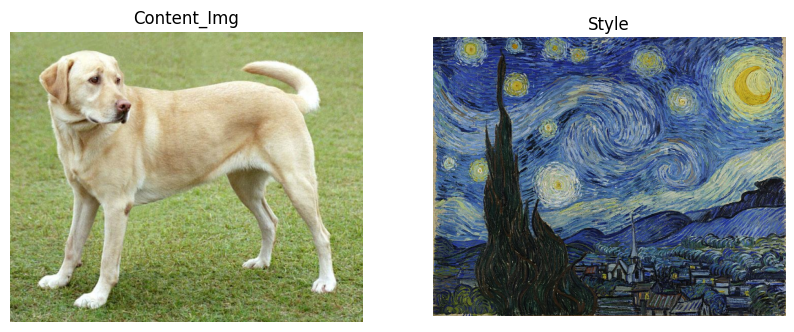

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(content_img[0])
plt.title('Content_Img')
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(style_img[0])
plt.title('Style')
plt.axis(False)

In [ ]:
x=tf.keras.applications.vgg19.preprocess_input(content_img*255)
x=tf.image.resize(x,(224,224))
vgg=tf.keras.applications.vgg19.VGG19(include_top=True)
prediction_prob=vgg(x)
prediction_prob.shape


TensorShape([1, 1000])

In [ ]:
top_5=tf.keras.applications.vgg19.decode_predictions(prediction_prob.numpy())[0]
[(class_name,prob) for (number,class_name,prob) in top_5 ]

[('Labrador_retriever', 0.49317107),
 ('golden_retriever', 0.23665293),
 ('kuvasz', 0.03635751),
 ('Chesapeake_Bay_retriever', 0.024182767),
 ('Greater_Swiss_Mountain_dog', 0.018646102)]

In [ ]:
vgg=tf.keras.applications.vgg19.VGG19(include_top=False)
for layer in vgg.layers:
  print(layer.name)

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

In [ ]:
content_style=style_layers+content_layers
content_style

['block1_conv1',
 'block2_conv1',
 'block3_conv1',
 'block4_conv1',
 'block5_conv1',
 'block5_conv2']

In [ ]:
def preprocess(img):
 return tf.keras.applications.vgg19.preprocess_input(img*255)

In [ ]:
def vgg_layer(layer_name):
  vgg.trainable=False
  outputs=[vgg.get_layer(name).output for name in layer_name]
  model=tf.keras.Model([vgg.input],outputs)
  return model

In [ ]:
style_extractor=vgg_layer(style_layers)
style_output=style_extractor.predict(preprocess(style_img))

1/1 [==============================] - 2s 2s/step


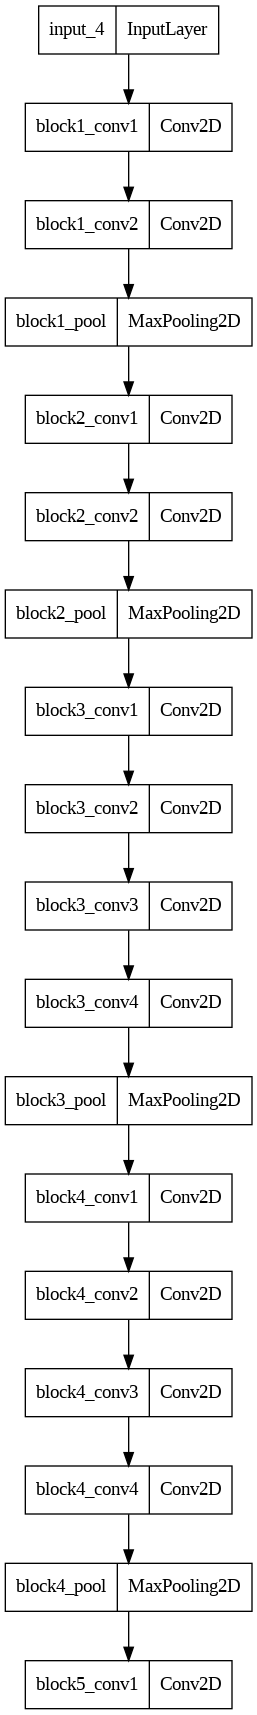

In [ ]:
tf.keras.utils.plot_model(style_extractor)

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

Lets Make the Targets

In [ ]:
style_targets=[gram_matrix(output) for output in style_output]


In [ ]:
content_extractor=vgg_layer(content_layers)
content_target=content_extractor.predict(preprocess(content_img))

1/1 [==============================] - 0s 134ms/step


In [ ]:
style_targets[0]

<tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
array([[[ 3028.3132 ,  1305.239  ,   627.6226 , ...,  1932.2902 ,
           705.9475 ,   969.0666 ],
        [ 1305.239  ,  2925.543  ,   873.67505, ...,  1360.959  ,
           919.1411 ,   686.35406],
        [  627.6226 ,   873.67505,   524.5921 , ...,   156.34958,
           509.05316,   539.2297 ],
        ...,
        [ 1932.2902 ,  1360.959  ,   156.34958, ..., 12767.09   ,
          1272.0499 ,   595.4115 ],
        [  705.9475 ,   919.1411 ,   509.05316, ...,  1272.0499 ,
          1379.937  ,   997.9705 ],
        [  969.0666 ,   686.35406,   539.2297 , ...,   595.4115 ,
           997.9705 ,  1040.9906 ]]], dtype=float32)>

In [ ]:
style_output[0].shape

(1, 405, 512, 64)

In [ ]:
image=tf.Variable(content_img)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image,clip_value_min=0.0,clip_value_max=1.0)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
content_model=vgg_layer(content_layers)
content_output=content_model(preprocess(content_img))
style_model=vgg_layer(style_layers)
style_output_=style_model.predict(preprocess(style_img))
image_style_output=[gram_matrix(output) for output in style_output_]

1/1 [==============================] - 0s 126ms/step


In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layer(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_img))


In [ ]:
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

In [ ]:
image = tf.Variable(content_img)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_layers)

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_layers)
    loss = style_loss + content_loss
    return loss

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
for i in range (500):
  train_step(image)


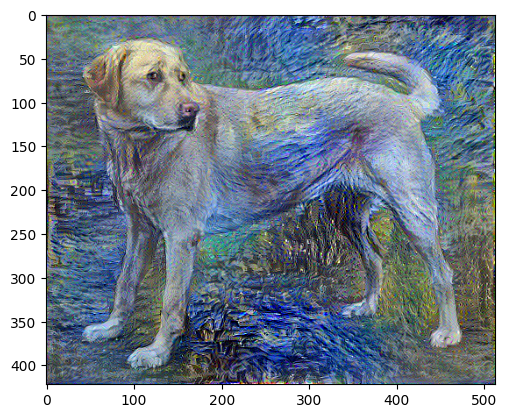

In [ ]:
plt.imshow(tensor_to_Image(image))